In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [5]:
# Load the dataset
df = pd.read_csv("cleaned_merged_data.csv")

# Selecting relevant categorical columns for ARM
columns_of_interest = ['Airline', 'Origin', 'Dest', 'DepTimeBlk', 'ArrTimeBlk', 'Cancelled', 'Diverted']
df_arm = df[columns_of_interest]

In [6]:
# Create transactions by merging the relevant columns into lists of 'items'
df_arm['transaction_items'] = df_arm.apply(lambda row: [str(row[col]) for col in columns_of_interest], axis=1)
transactions = df_arm['transaction_items'].tolist()

# Convert the transaction data to a format suitable for ARM (One-Hot Encoding)
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

<ipython-input-6-ec96be230aee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arm['transaction_items'] = df_arm.apply(lambda row: [str(row[col]) for col in columns_of_interest], axis=1)


In [7]:
# Apply the Apriori Algorithm to find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
print("\nFrequent Itemsets:")
print(frequent_itemsets.head())

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print("\nAssociation Rules:")
print(rules.head())


Frequent Itemsets:
    support     itemsets
0  0.049756  (0001-0559)
1  0.147946  (0600-0659)
2  0.141082  (0700-0759)
3  0.146548  (0800-0859)
4  0.100681  (0900-0959)

Association Rules:
   antecedents  consequents  antecedent support  consequent support   support  \
0  (0001-0559)  (0700-0759)            0.049756            0.141082  0.018808   
1  (0700-0759)  (0001-0559)            0.141082            0.049756  0.018808   
2  (0001-0559)        (DEN)            0.049756            1.000000  0.049756   
3        (DEN)  (0001-0559)            1.000000            0.049756  0.049756   
4  (0001-0559)      (False)            0.049756            1.000000  0.049756   

   confidence      lift  representativity  leverage  conviction  \
0    0.378000  2.679292               1.0  0.011788    1.380897   
1    0.133311  2.679292               1.0  0.011788    1.096407   
2    1.000000  1.000000               1.0  0.000000         inf   
3    0.049756  1.000000               1.0  0.000000    

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [9]:
# Top 15 rules based on different metrics
top_15_support_df = rules.nlargest(15, 'support')
top_15_confidence_df = rules.nlargest(15, 'confidence')
top_15_lift_df = rules.nlargest(15, 'lift')

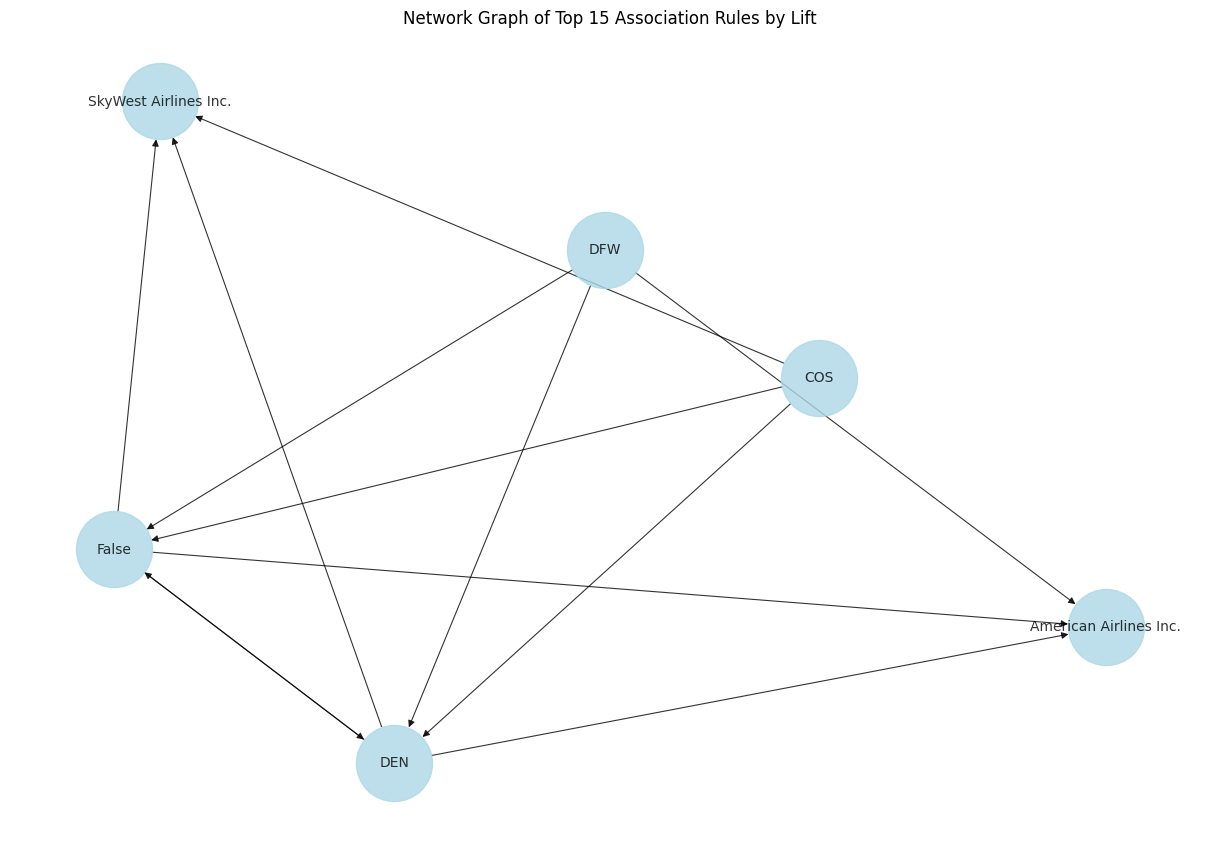

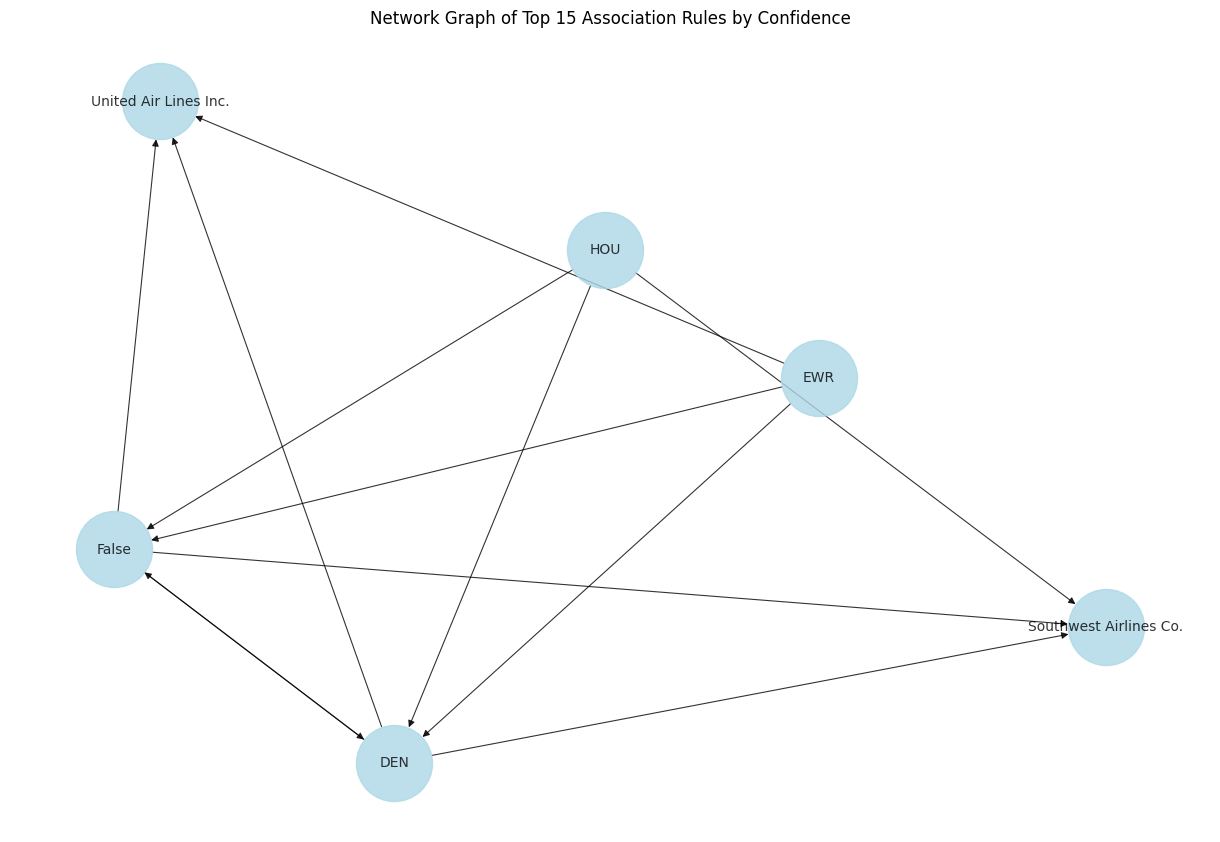

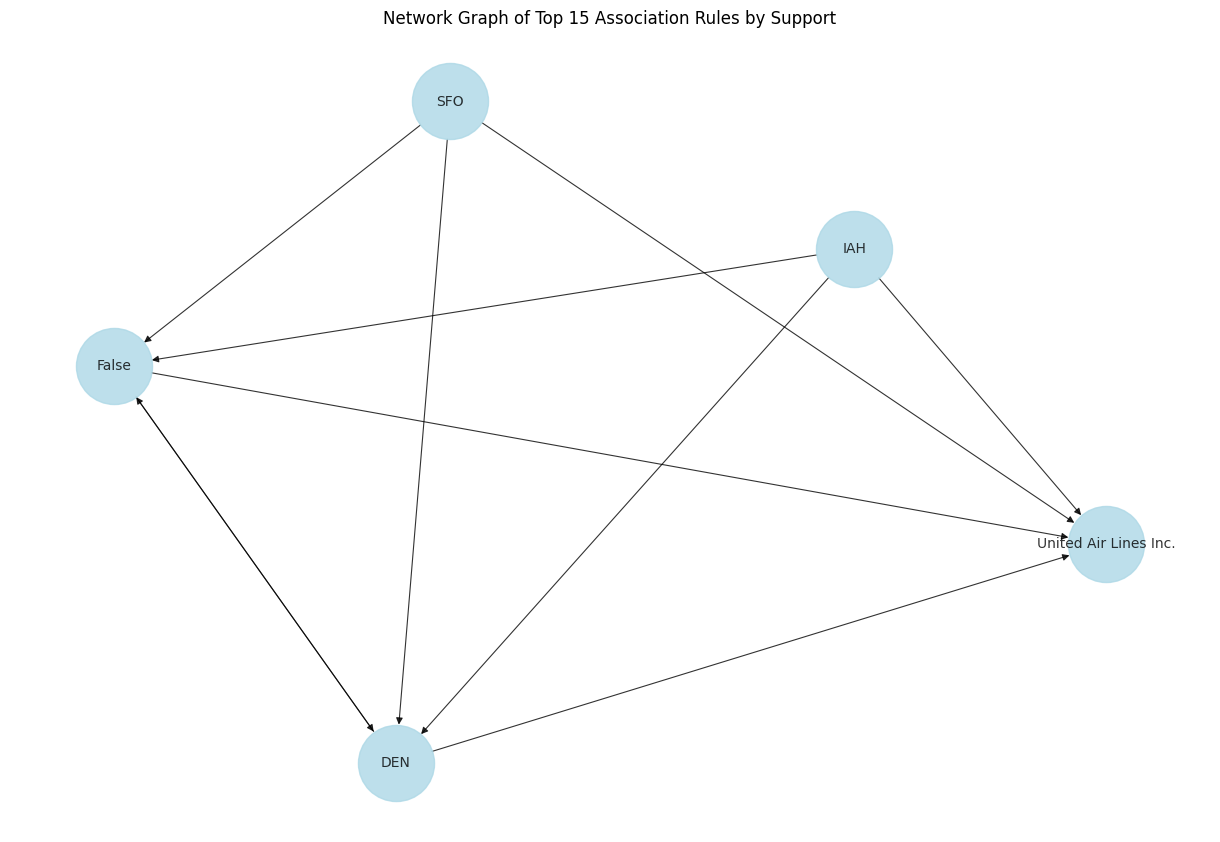

In [25]:
# Function to create a clean and well-structured network graph
def plot_association_rules(rules, metric, title):
    G = nx.DiGraph()

    for idx, rule in rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])

        for node in antecedents:
            G.add_node(node)
        for node in consequents:
            G.add_node(node)

        for antecedent in antecedents:
            for consequent in consequents:
                G.add_edge(antecedent, consequent, weight=0.5)  # Standardized thinner edge thickness

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, seed=42)  # Improve spacing
    edge_weights = [0.8 for _ in G.edges]  # Standardized edge thickness for consistency

    nx.draw(G, pos, with_labels=True, node_size=3000, font_size=10,
            node_color='lightblue', edge_color='black', width=edge_weights, alpha=0.8)

    plt.title(f'Network Graph of Top 15 Association Rules by {title}')
    plt.show()

# Plot the network graphs for each metric
plot_association_rules(top_15_lift_df, 'lift', 'Lift')
plot_association_rules(top_15_confidence_df, 'confidence', 'Confidence')
plot_association_rules(top_15_support_df, 'support', 'Support')

**Observations from the Network Graph of Top 15 Association Rules by Lift:**

The network graph highlights strong associations between airlines, airports, and flight conditions based on lift-based association rules. "DEN" (Denver International Airport) and "DFW" (Dallas/Fort Worth International Airport) are key hubs, frequently appearing in rules, indicating their operational significance. "False" (likely representing cancellations or delays) is strongly connected, suggesting recurring disruptions at certain locations. "SkyWest Airlines Inc." and "American Airlines Inc." show frequent associations with specific airports, hinting at common operational patterns. The graph reveals high-confidence relationships, helping airlines and airport authorities optimize **scheduling, resource allocation, and disruption management to improve efficiency.

**Observations from the Network Graph of Top 15 Association Rules by Confidence:**

The network graph based on confidence-based association rules highlights stronger and more reliable relationships between airlines, airports, and flight conditions. "DEN" (Denver International Airport), "HOU" (Houston), and "EWR" (Newark) appear as central nodes, indicating frequent and highly confident associations with other elements. "False" (possibly indicating cancellations or delays) is again a key node, reinforcing its impact on flight patterns. "United Airlines Inc." and "Southwest Airlines Co." have high-confidence connections, suggesting consistent operational behaviors with specific airports. This graph provides insights into highly reliable correlations, helping airlines and airport authorities optimize operations and mitigate disruptions more effectively.

**Observations from the Network Graph of Top 15 Association Rules by support:**

The network graph based on support-based association rules highlights frequent co-occurrences between key airports, airlines, and flight conditions. "DEN" (Denver), "SFO" (San Francisco), and "IAH" (Houston) are central nodes, showing they frequently appear in flight transactions. "False" (likely cancellations or delays) has strong links, reinforcing its high frequency in travel disruptions. "United Airlines Inc." is significantly connected, indicating it has high-volume routes across these key airports. This graph provides insights into the most commonly occurring patterns, helping airlines and airports prioritize operational improvements for efficiency.